In [1]:
!pip install opendatasets


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import json
import logging

In [3]:
import opendatasets as od

In [4]:
import sqlite3

import pandas as pd
import seaborn as se
import matplotlib.pyplot as plt

In [5]:
dataset_name = "gregorut/videogamesales"
filename = "video_game_sales.csv.zip"

In [6]:
working_folder = os.getcwd()

In [7]:
os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""

In [8]:
# Set the authentication credentials for kaggle
kaggle_auth = {"username":os.environ['KAGGLE_USERNAME'],"key":os.environ['KAGGLE_KEY']}

In [9]:
# Load the dataset
dataset_folder = os.path.join(working_folder, "videogamesales")
dataset_file = os.path.join(dataset_folder, "vgsales.csv")

In [10]:
if not os.path.exists('./kaggle.json'):
    with open('./kaggle.json', 'w') as f:
        json.dump(kaggle_auth, f)

In [11]:
if not os.path.exists(dataset_folder):
    od.download(f"https://www.kaggle.com/{dataset_name}",working_folder)
else:
    logging.info("El dataset ya está descargado.")

In [12]:
# Read the dataset
df = None
if os.path.exists(dataset_file):
    try:
        df = pd.read_csv(dataset_file)
    except Exception as e:
        logging.error(f"Error reading the dataset: {e}")
        raise Exception("Error reading the dataset")
else:
    raise Exception("The dataset file does not exist")

In [13]:
df.columns

Index(['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'],
      dtype='object')

In [14]:
df.shape

(16598, 11)

In [15]:
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


## Limpieza:
- Se deben eliminar filas con valores faltantes en columnas críticas para el análisis (ej. Nombre del Juego, Año de Lanzamiento).
- Se deben corregir errores de formato en columnas como "Año de Lanzamiento" (ej. convertir a formato de fecha).
- Se deben eliminar columnas irrelevantes para el análisis (ej. ID del juego).

In [16]:
# 1.1 Remove rows with empty values on "Name"
df = df.dropna(subset=["Name"])

In [17]:
# 1.2 Remove rows with empty values on "Year"
df["Year"] = pd.to_numeric(df["Year"], errors="coerce")
df = df.dropna(subset=["Year"])
df["Year"] = df["Year"].astype(int)

In [18]:
# 3 Remove columns irrelevant for the analysis
if "Rank" in df.columns:
    df = df.drop(columns=["Rank"])

## Enriquecimiento:
- Se debe crear una nueva columna "Década de Lanzamiento" basada en la columna "Año de Lanzamiento".
- Se deben calcular métricas relevantes como "Ventas Totales" (suma de ventas globales).

In [19]:
# 4 Create a new column "Decade" based on the "Year" column
df["Decade"] = df["Year"] // 10 * 10
# set Decade to integer value for better visualization
df["Decade"] = df["Decade"].astype(int)

In [20]:
# 5 Check the number of games per decade
df["Decade"].value_counts().sort_index()

Decade
1980     205
1990    1769
2000    9208
2010    5144
2020       1
Name: count, dtype: int64

In [21]:
df["Total_Sales"] = df[["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]].sum(axis=1)

## Agregación:
- Se deben agrupar los datos por categorías como "Género", "Plataforma" y "Década de Lanzamiento".
- Se deben calcular estadísticas como "Ventas Promedio" y "Cantidad de Juegos" para cada grupo.

In [22]:
# 6.1 Group the data by Genre, sum NA_Sales, sum EU_Sales, sum JP_Sales, sum Other_Sales, sum Global_Sales
genre_group = df.groupby("Genre").agg({
    "NA_Sales": ["sum", "mean"],
    "EU_Sales": ["sum", "mean"],
    "JP_Sales": ["sum", "mean"],
    "Other_Sales": ["sum", "mean"],
    "Global_Sales": ["sum", "mean"],
    "Name": "count"
}).reset_index()

In [23]:
# 6.2 Group the data by Platform
platform_group = df.groupby("Platform").agg({
    "NA_Sales": ["sum", "mean"],
    "EU_Sales": ["sum", "mean"],
    "JP_Sales": ["sum", "mean"],
    "Other_Sales": ["sum", "mean"],
    "Global_Sales": ["sum", "mean"],
    "Name": "count"
}).reset_index()

In [24]:
# 6.3 Group the data by Decade of Release
decade_group = df.groupby("Decade").agg({
    "NA_Sales": ["sum", "mean"],
    "EU_Sales": ["sum", "mean"],
    "JP_Sales": ["sum", "mean"],
    "Other_Sales": ["sum", "mean"],
    "Global_Sales": ["sum", "mean"],
    "Name": "count"
}).reset_index()

In [25]:
genre_group.to_csv("genre_group.csv",index=False)
platform_group.to_csv("platform_group.csv",index=False)
decade_group.to_csv("decade_group.csv",index=False)

In [26]:
df.to_csv("vgsales_transformado.csv",index=False)

In [27]:
conn = sqlite3.connect("vgsales.db")
df.to_sql("video_game_sales", conn, if_exists="replace", index=False)
conn.close()


In [28]:
se.color_palette("viridis")

[(0.275191, 0.194905, 0.496005),
 (0.212395, 0.359683, 0.55171),
 (0.153364, 0.497, 0.557724),
 (0.122312, 0.633153, 0.530398),
 (0.288921, 0.758394, 0.428426),
 (0.626579, 0.854645, 0.223353)]

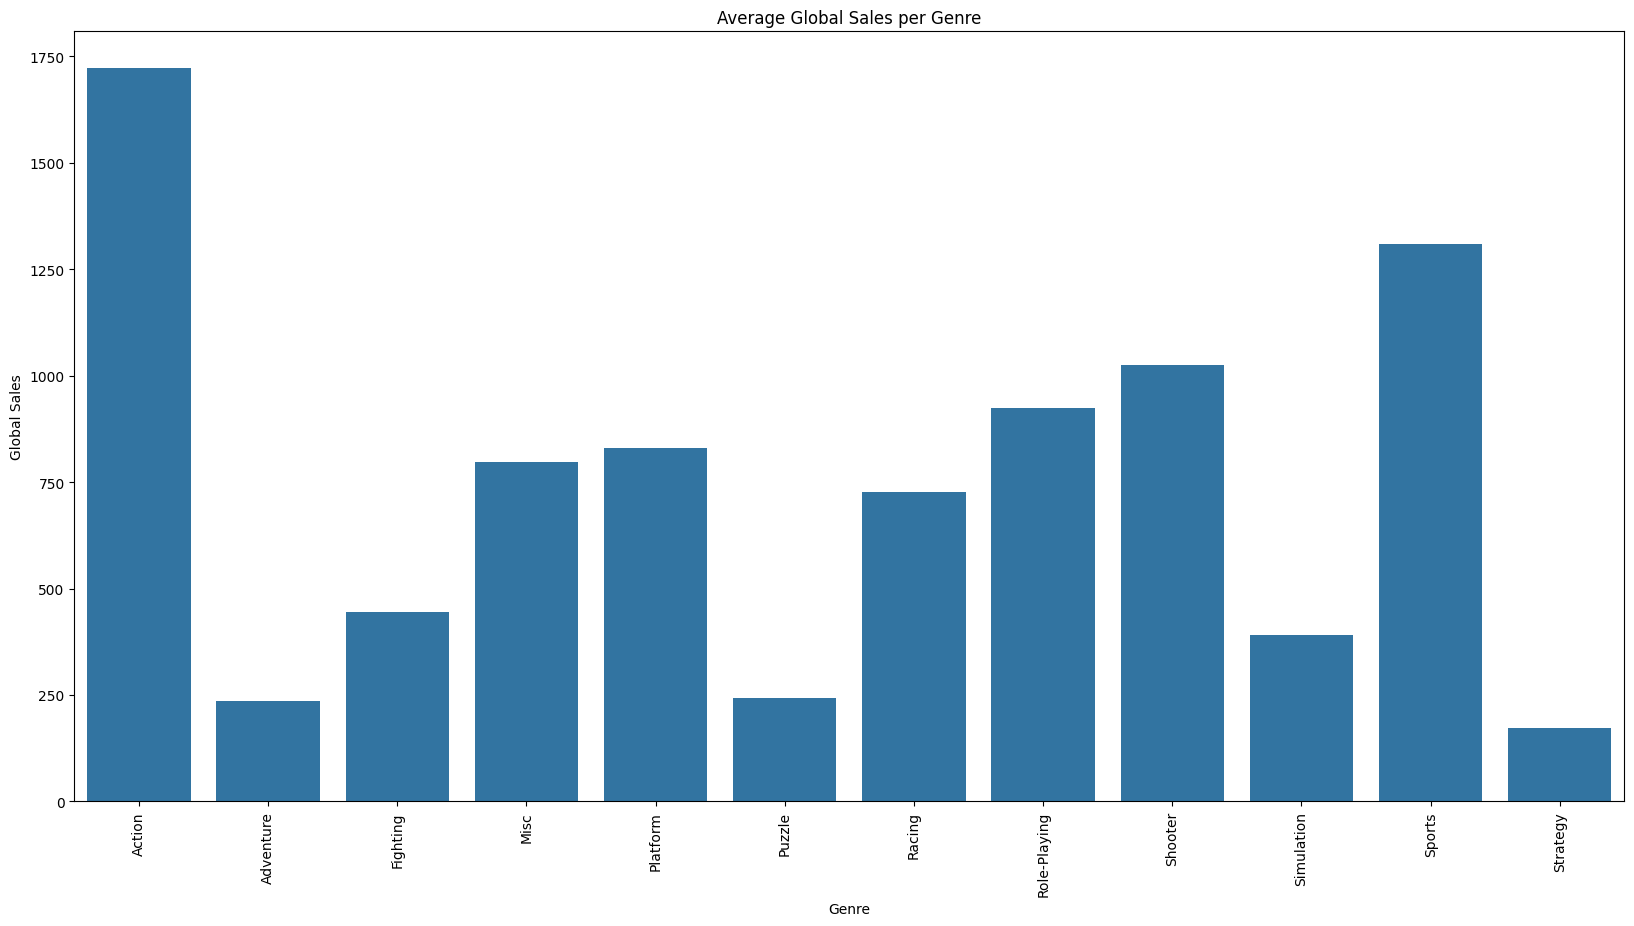

In [29]:
# Create a graph using seaborn by genre_group
genre_group_mean = df.groupby("Genre").agg({"Global_Sales": "sum"}).reset_index()

plt.figure(figsize=(20,10))
se.barplot(data=genre_group_mean, x="Genre", y="Global_Sales", errorbar=None)
plt.title("Average Global Sales per Genre")
plt.ylabel("Global Sales")
plt.xticks(rotation=90)
plt.show()

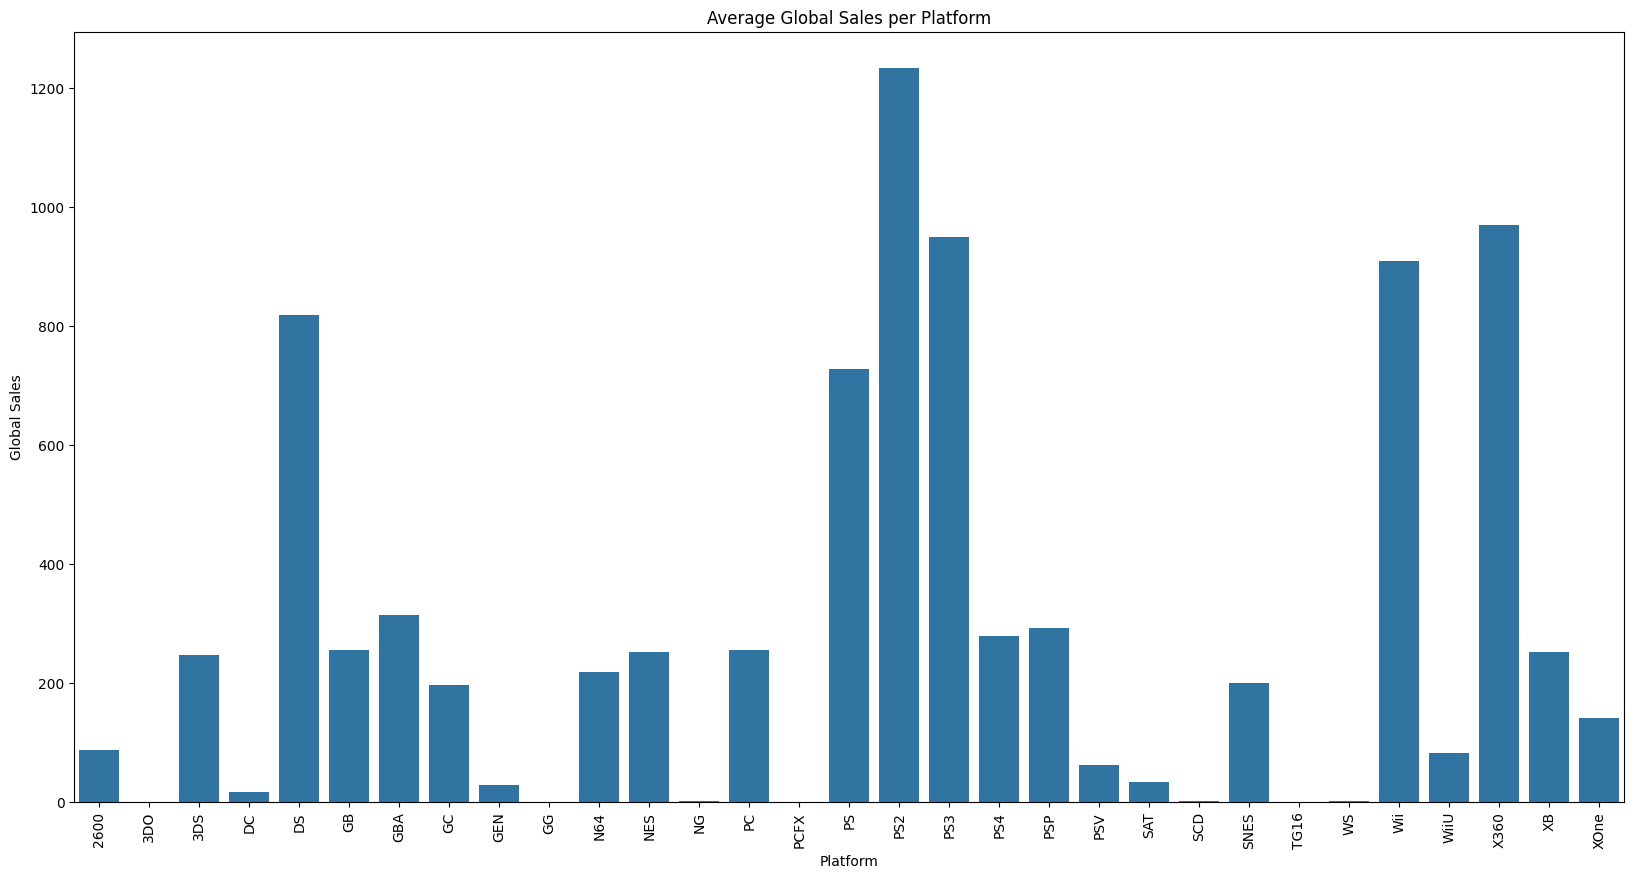

In [30]:
# Create a graph using seaborn by platform_group
platform_group_mean = df.groupby("Platform").agg({"Global_Sales": "sum"}).reset_index()

plt.figure(figsize=(20,10))
se.barplot(data=platform_group_mean, x="Platform", y="Global_Sales", errorbar=None)
plt.title("Average Global Sales per Platform")
plt.ylabel("Global Sales")
plt.xticks(rotation=90)
plt.show()

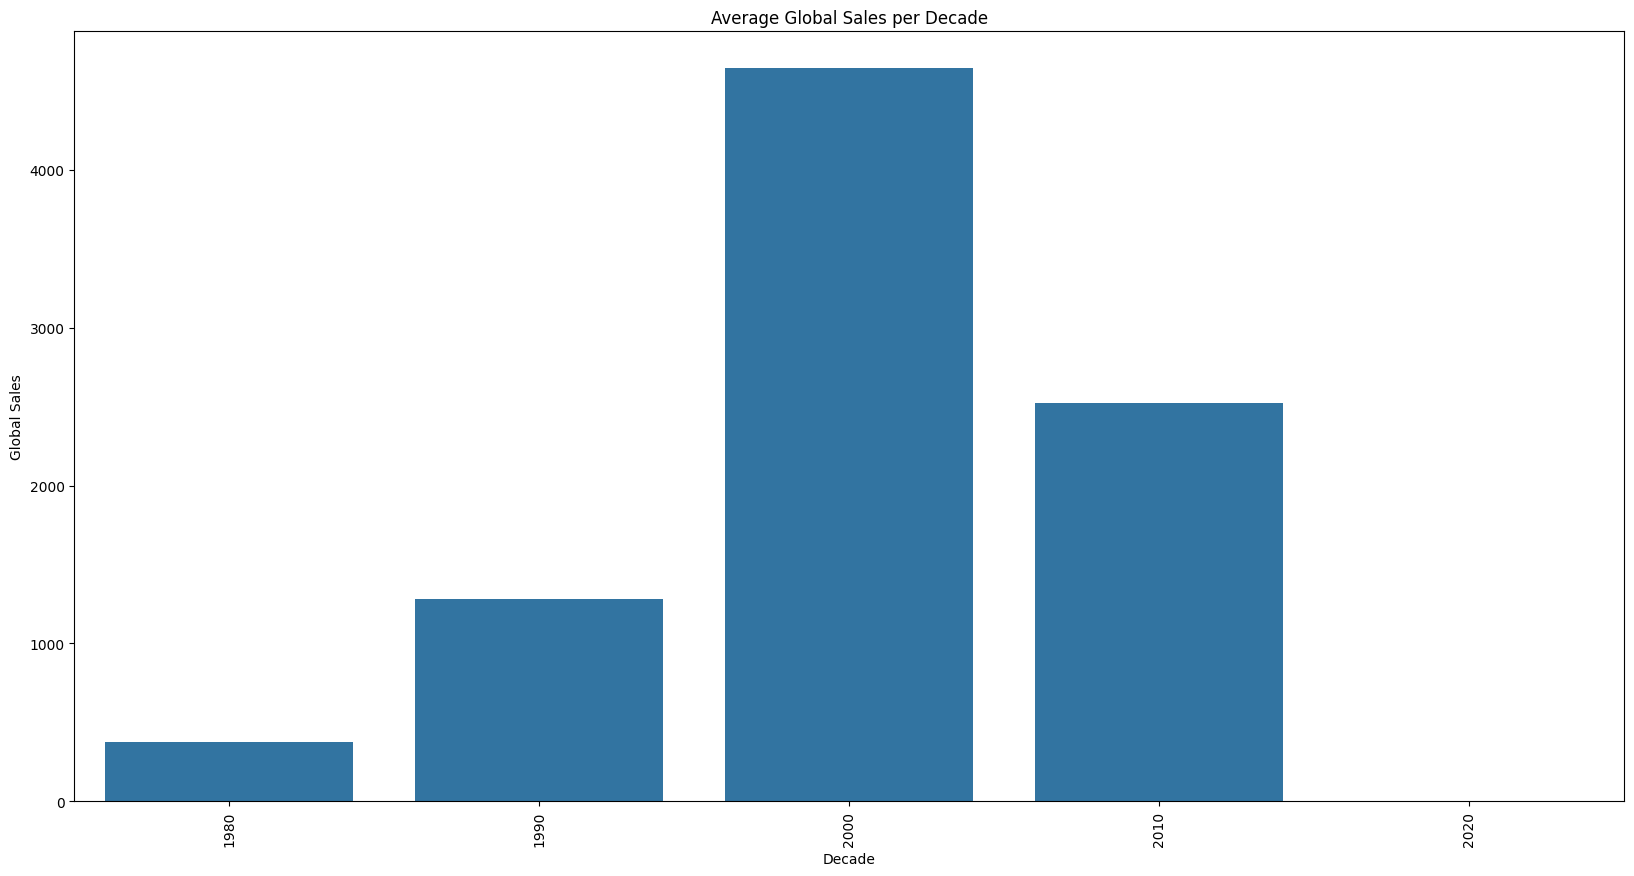

In [31]:
# Create a graph using seaborn by platform_group
decade_group_mean = df.groupby("Decade").agg({"Global_Sales": "sum"}).reset_index()

plt.figure(figsize=(20,10))
se.barplot(data=decade_group_mean, x="Decade", y="Global_Sales", errorbar=None)
plt.title("Average Global Sales per Decade")
plt.ylabel("Global Sales")
plt.xticks(rotation=90)
plt.show()